In [1]:
import scanpy as sc
import anndata as ad
import infercnvpy as cnv 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
adata = sc.read_h5ad("/data/hanxue/hanxue_data/adata-xwt-annotated.h5ad")
adata

AnnData object with n_obs × n_vars = 159054 × 41733
    obs: 'batch', 'mt_frac', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'leiden', 'major_type', 'molecular_type', 'leiden_harmony', 'major_type_harmony', 'minor_type', 'minor-type', 'gender', 'doublet_score', 'predicted_doublet', 'leiden-harmony-female', 'majorType-Female', 'epi-subtype', 'treat', 'leiden-1', 'annotation'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'annotation_colors', 'batch_colors', 'dendrogram_annotation', 'dendrogram_leiden', 'dendrogram_leiden-1', 'gender_colors', 'hvg', 'leiden', 'leiden-1_colors', 'leiden-harmony-female_colors', 'leiden_colors', 'leiden_harmony_colors', 'log1p', 'majorType-Female_colors', 'major_type_colors', 'major_type_harmony_colors', 'minor-type_colors', 'minor_

In [3]:
def MergeSubAdata(adata, subAdata, obsName, subObsName):
    obs = pd.Series(list(adata.obs[obsName].copy()), index=adata.obs_names)
    subObs = pd.Series(list(subAdata.obs[subObsName].copy()), index=subAdata.obs_names)
    obs.loc[subObs.index] = subObs
    return pd.DataFrame(obs, columns=[obsName])


def marker(adata, groupby, method='wilcoxon', prefix=''):
    sc.tl.rank_genes_groups(adata, groupby = groupby, method = method)
    sc.tl.dendrogram(adata, groupby=groupby, use_rep='X_pca_harmony')
    sc.pl.rank_genes_groups_dotplot(adata, groupby = groupby, save=prefix+groupby+'.svg')
    return adata

def clu(adata, key_added="majorType-fix", n_neighbors=50, n_pcs=30, rep='X_pca_harmony', do_har=True, max_iter=20, do_scrublet=False, har_key='batch', resolution=1):
    # Computing the neighborhood graph
    if do_scrublet:
        n0 = adata.shape[0]
        print("{0} Cell number: {1}".format(key_added, n0))
        sc.external.pp.scrublet(adata)
        adata = adata[adata.obs['predicted_doublet']==False,:].copy()
        print("{0} Cells retained after scrublet, {1} cells reomved.".format(adata.shape[0], n0-adata.shape[0]))
    else:
        print("Ignoring processing doublet cells...")
    if do_har and len(adata.obs[har_key].cat.categories) > 1:
        sc.external.pp.harmony_integrate(adata, key=har_key,max_iter_harmony=max_iter)
        sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, use_rep=rep)
    else:
        print("Evaluating neighbors only...")
        sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, use_rep=rep)
    # Run UMAP
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=resolution, key_added=key_added)
    sc.pl.umap(adata, color=key_added, legend_fontoutline=True, palette=sc.pl.palettes.default_20, legend_loc="on data")
    return adata

In [4]:
# 筛选出成纤维
adata_Fib = adata[adata.obs['major_type'] == 'Fibroblast', :]
adata_Fib

View of AnnData object with n_obs × n_vars = 21292 × 41733
    obs: 'batch', 'mt_frac', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'leiden', 'major_type', 'molecular_type', 'leiden_harmony', 'major_type_harmony', 'minor_type', 'minor-type', 'gender', 'doublet_score', 'predicted_doublet', 'leiden-harmony-female', 'majorType-Female', 'epi-subtype', 'treat', 'leiden-1', 'annotation'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'annotation_colors', 'batch_colors', 'dendrogram_annotation', 'dendrogram_leiden', 'dendrogram_leiden-1', 'gender_colors', 'hvg', 'leiden', 'leiden-1_colors', 'leiden-harmony-female_colors', 'leiden_colors', 'leiden_harmony_colors', 'log1p', 'majorType-Female_colors', 'major_type_colors', 'major_type_harmony_colors', 'minor-type_colors', 

Ignoring processing doublet cells...


2025-09-28 08:15:39,001 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-09-28 08:15:41,944 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-09-28 08:15:42,014 - harmonypy - INFO - Iteration 1 of 20
2025-09-28 08:15:46,092 - harmonypy - INFO - Iteration 2 of 20
2025-09-28 08:15:50,027 - harmonypy - INFO - Iteration 3 of 20
2025-09-28 08:15:53,887 - harmonypy - INFO - Iteration 4 of 20
2025-09-28 08:15:57,042 - harmonypy - INFO - Iteration 5 of 20
2025-09-28 08:15:59,599 - harmonypy - INFO - Converged after 5 iterations
/home/hanxue/miniconda3/envs/omicverse/lib/python3.10/site-packages/scanpy/external/pp/_harmony_integrate.py:101: ImplicitModificationWarning: Setting element `.obsm['X_pca_harmony']` of view, initializing view as actual.
  adata.obsm[adjusted_basis] = harmony_out.Z_corr.T
/home/hanxue/miniconda3/envs/omicverse/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB versi

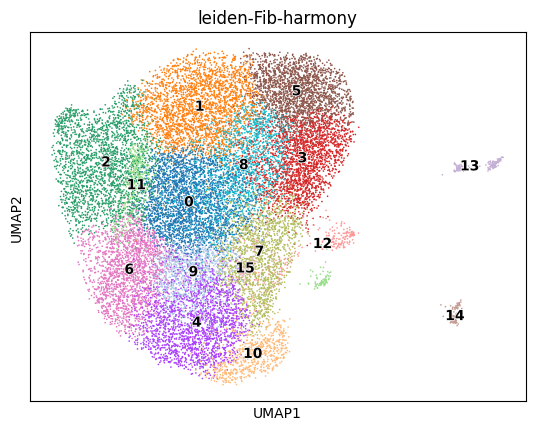

In [5]:
adata_Fib = clu(adata_Fib, "leiden-Fib-harmony", resolution=1)

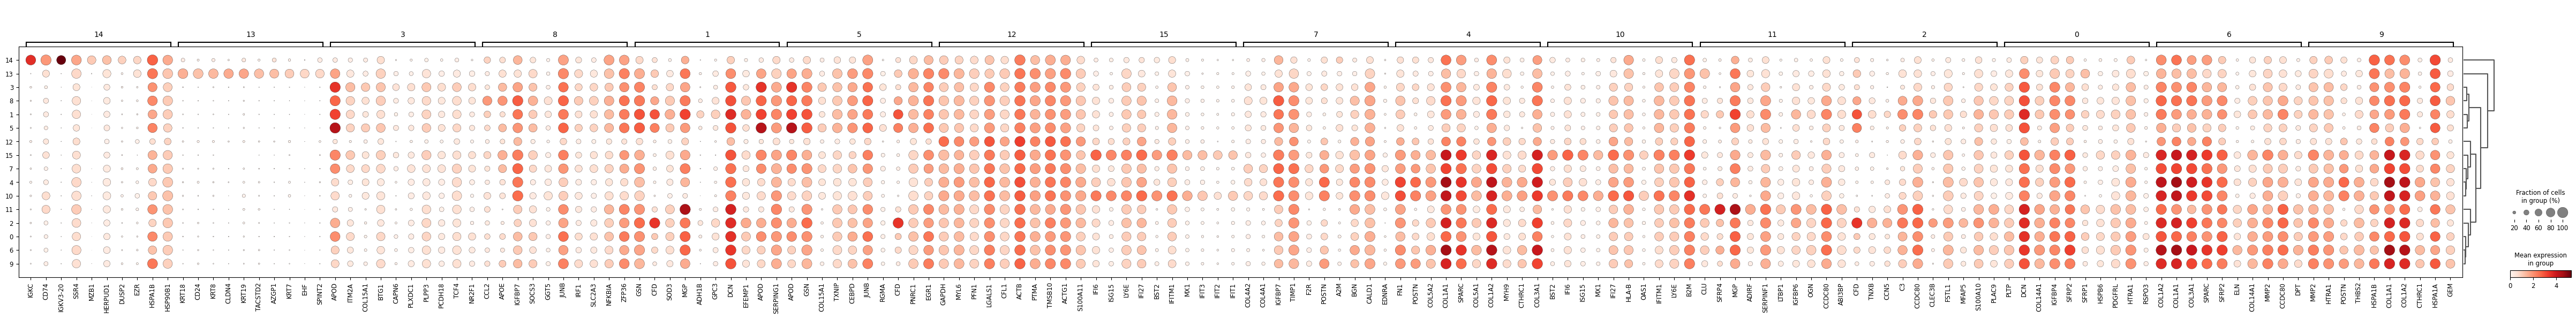

In [10]:
adata_Fib = marker(adata_Fib, 'leiden-Fib-harmony')

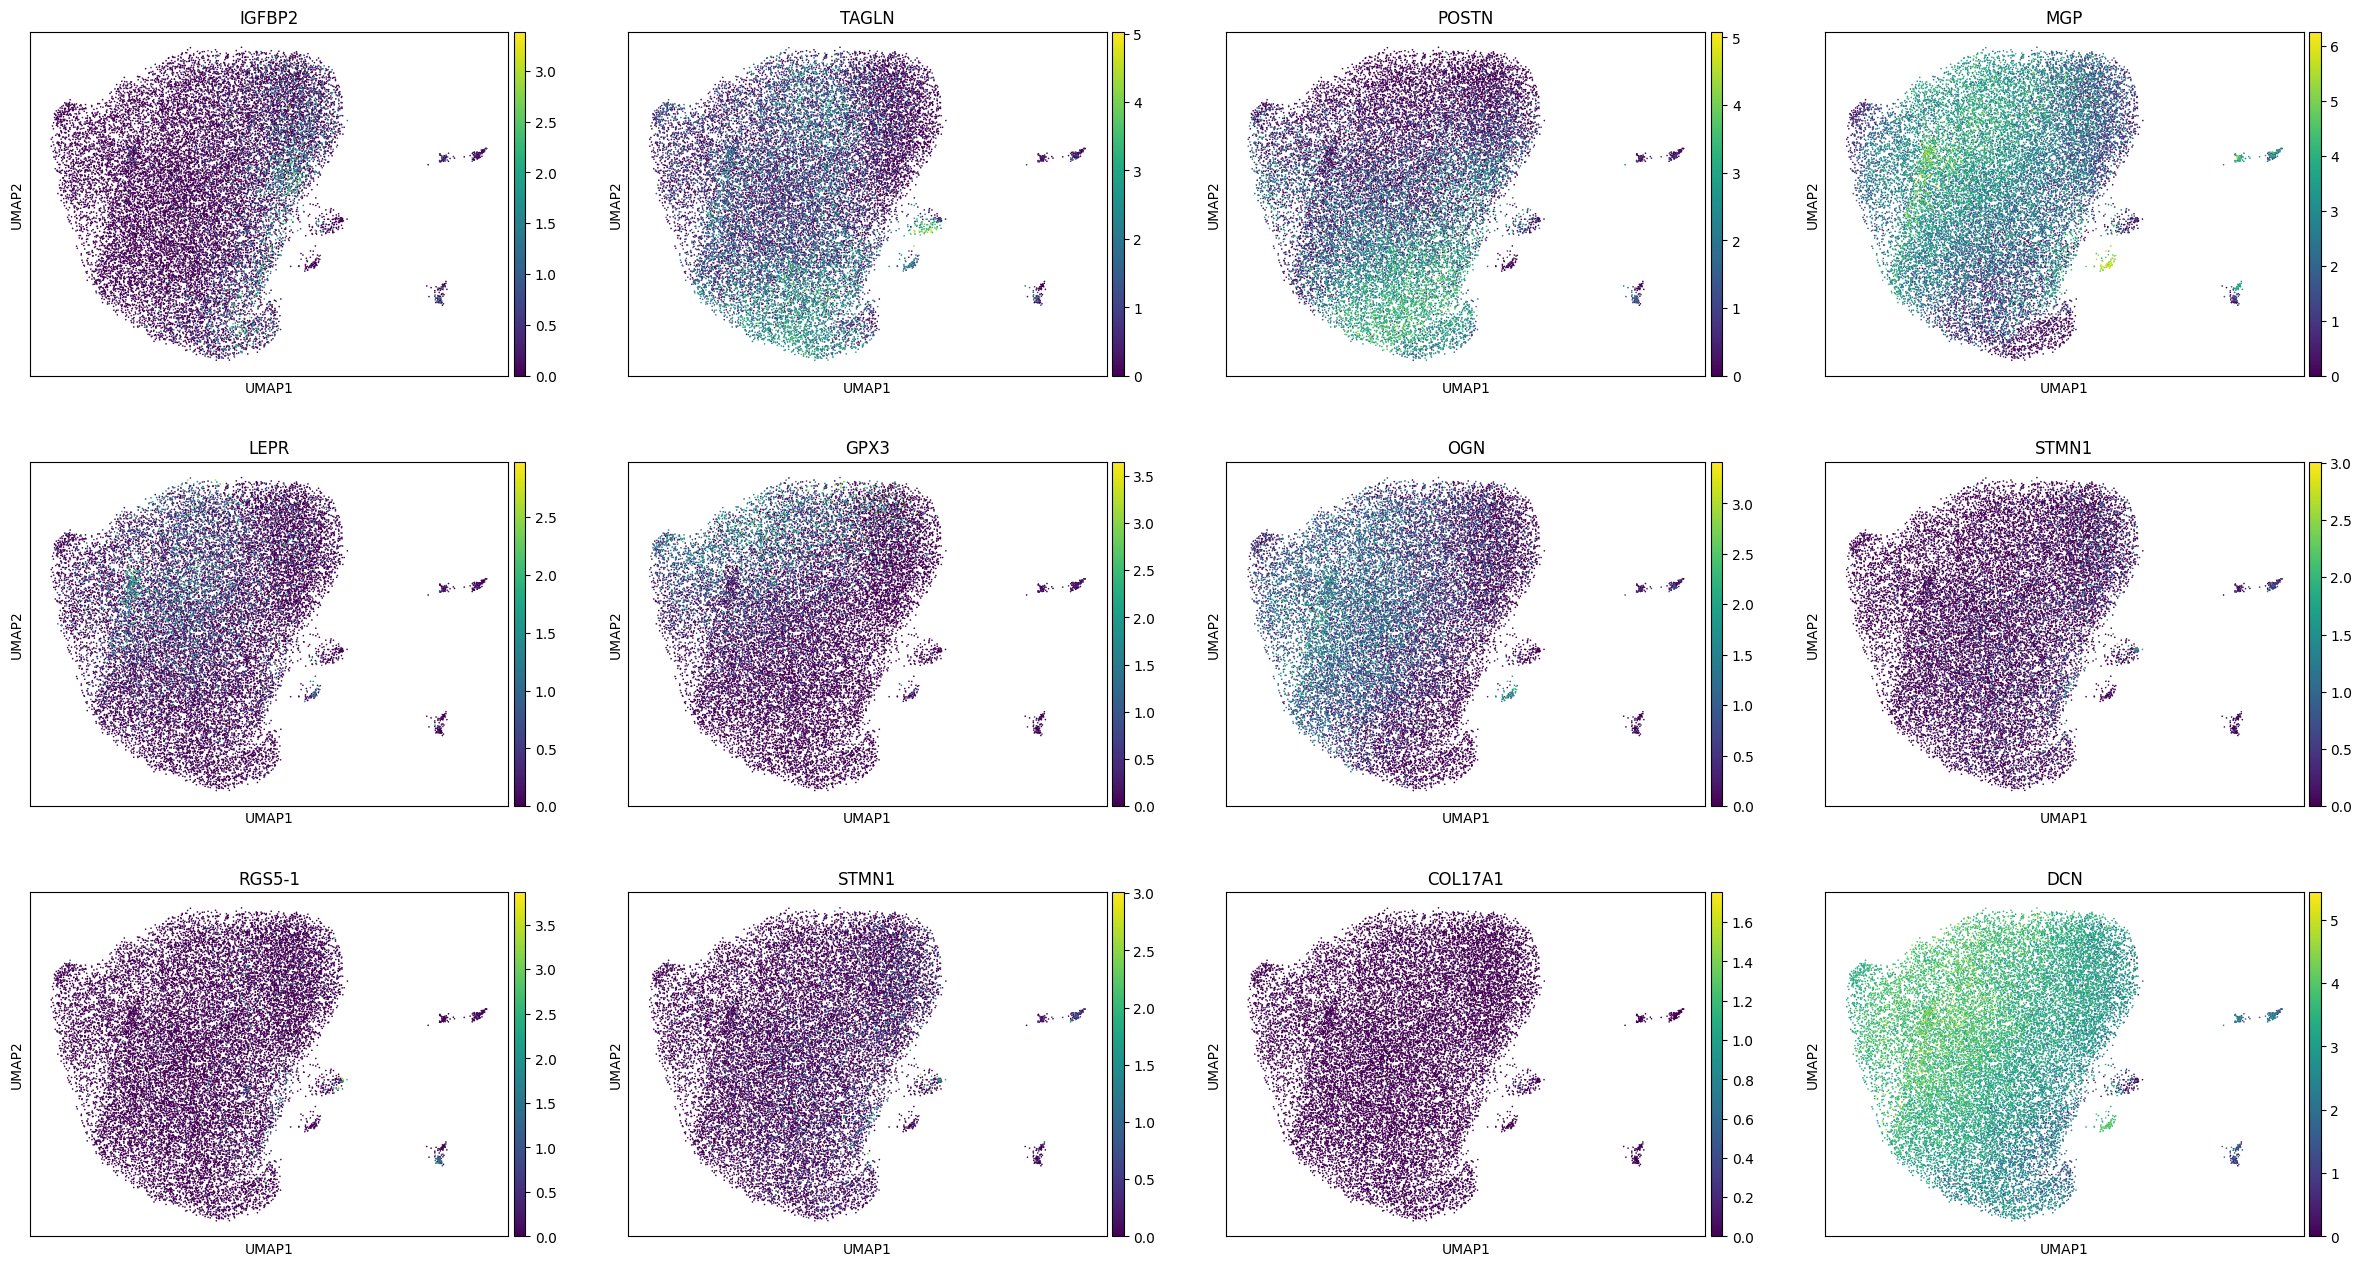

In [18]:
sc.pl.umap(adata_Fib, color=['IGFBP2','TAGLN', 'POSTN', 'MGP', 'LEPR','GPX3', 'OGN', 'STMN1','RGS5-1', 'STMN1','COL17A1'], 
           legend_fontoutline=True, palette=sc.pl.palettes.default_20, legend_loc="on data")

```
CAFs: FAP S100A4 ATAC2 RGS5 TAGLN CTHRC1
NFs: DCN IGFBP6 MFAP5
```

categories: 0, 1, 2, etc.
var_group_labels: CAF_myo, CAF_inf_ECM, CAF_anti_pre, etc.


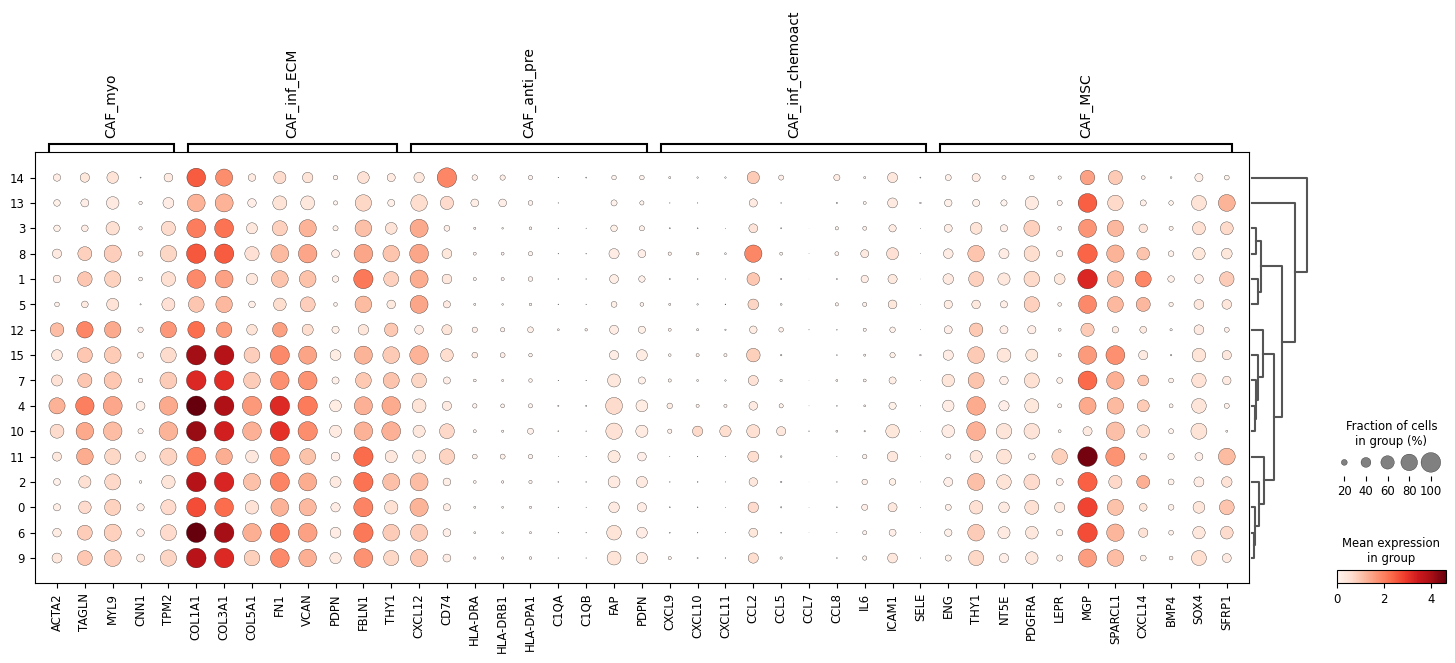

In [13]:
marker_dict = {
    "CAF_myo": [
        "ACTA2", "TAGLN", "MYL9", "CNN1", "TPM2"
    ],
    "CAF_inf_ECM": [
        "COL1A1", "COL3A1", "COL5A1", "FN1", "VCAN", "PDPN", "FBLN1", "THY1"
    ],
    "CAF_anti_pre": [
        "CXCL12", "CD74", "HLA-DRA", "HLA-DRB1", "HLA-DPA1", "C1QA", "C1QB",  "FAP", "PDPN"
    ],
    "CAF_inf_chemoact": [
        "CXCL9", "CXCL10", "CXCL11", "CCL2", "CCL5", "CCL7", "CCL8", "IL6", "ICAM1", "SELE"
    ],
    "CAF_MSC": [
        "ENG", "THY1", "NT5E", "PDGFRA", "LEPR", "MGP", "SPARCL1", "CXCL14", "BMP4", "SOX4", "SFRP1"
    ]
}

sc.pl.dotplot(adata_Fib, marker_dict, groupby='leiden-Fib-harmony',dendrogram=True)

In [ ]:
adata_Fib.obs['Fib-type'] = 'Fibroblast'
adata_Fib.obs.loc[  
    adata_Fib.obs["leiden-Fib-harmony"].isin(['3', '8', '1', '5',  '12']), "Fib-type"
] = "CAF myo"
adata_Fib.obs.loc[  
    adata_Fib.obs["leiden-Fib-harmony"].isin(['15', '7', '4', '10', '0', '6', '9', '2']), "Fib-type"
] = "CAF inf ECM"
adata_Fib.obs.loc[  
    adata_Fib.obs["leiden-Fib-harmony"].isin(['14']), "Fib-type"
] = "CAF anti-pre"
adata_Fib.obs.loc[  
    adata_Fib.obs["leiden-Fib-harmony"].isin(['8']), "Fib-type"
] = "CAF inf chemoact"
adata_Fib.obs.loc[  
    adata_Fib.obs["leiden-Fib-harmony"].isin(['11']), "Fib-type"
] = "CAF MSC"
adata_Fib.obs.loc[
    adata_Fib.obs["leiden-Fib-harmony"].isin([ '13']), "Fib-type"
] = "Basal Normal"
sc.pl.umap(adata_Fib, color='Fib-type')

categories: 0, 1, 2, etc.
var_group_labels: myCAF, iCAF, ECM-CAF, etc.


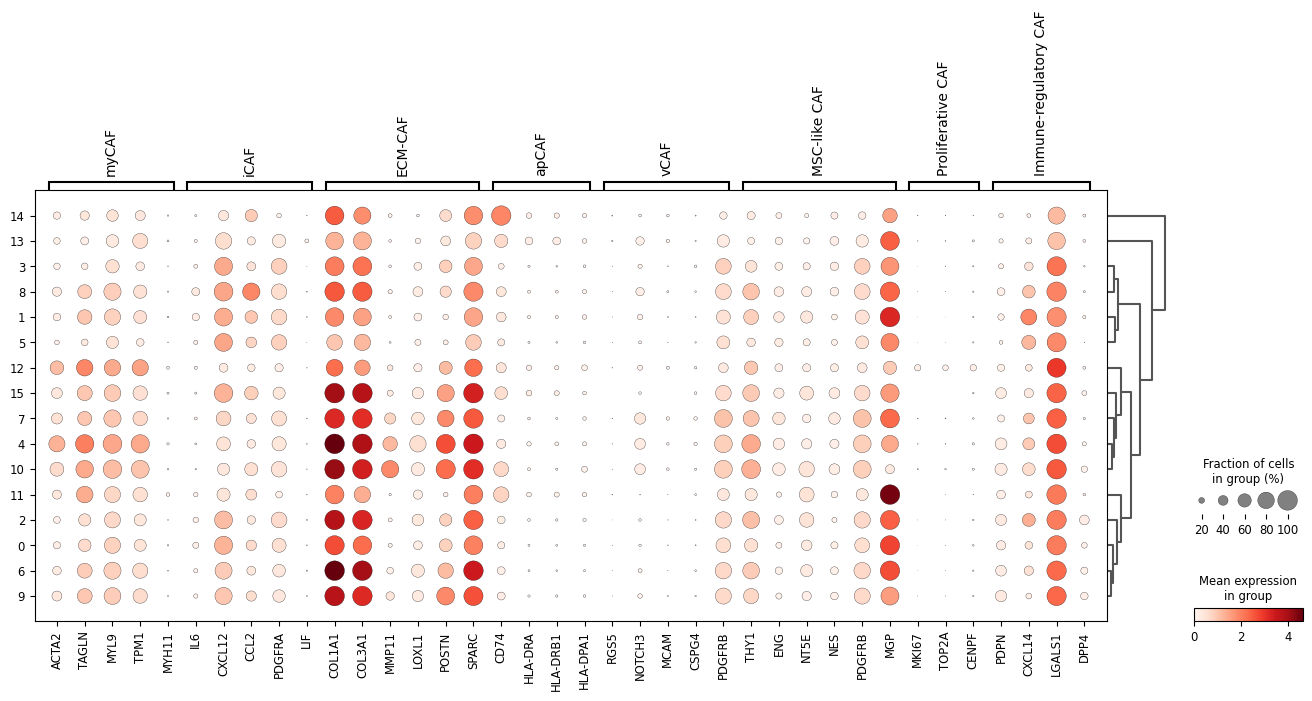

In [17]:
marker_dict = {
    "myCAF": ["ACTA2", "TAGLN", "MYL9", "TPM1", "MYH11"],
    "iCAF": ["IL6", "CXCL12", "CCL2", "PDGFRA", "LIF"],
    "ECM-CAF": ["COL1A1", "COL3A1", "MMP11", "LOXL1", "POSTN", "SPARC"],
    "apCAF": ["CD74", "HLA-DRA", "HLA-DRB1", "HLA-DPA1"],
    "vCAF": ["RGS5", "NOTCH3", "MCAM", "CSPG4", "PDGFRB"],
    "MSC-like CAF": ["THY1", "ENG", "NT5E", "NES", "PDGFRB", "MGP"],
    "Proliferative CAF": ["MKI67", "TOP2A", "CENPF"],
    "Immune-regulatory CAF": ["PDPN", "CXCL14", "LGALS1", "DPP4"]
}
sc.pl.dotplot(adata_Fib, marker_dict, groupby='leiden-Fib-harmony',dendrogram=True)

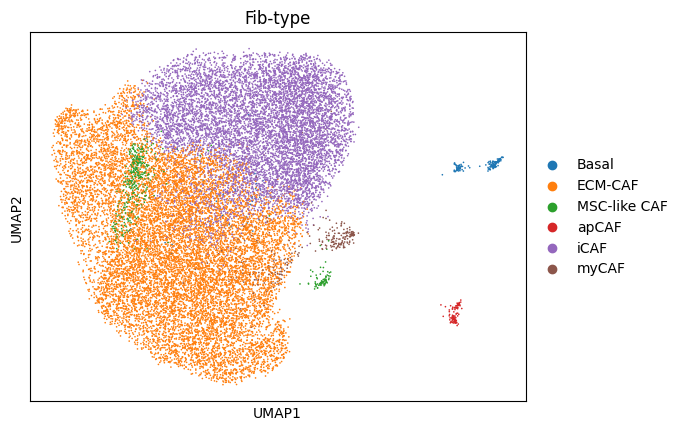

In [7]:
adata_Fib.obs['Fib-type'] = 'Fibroblast'
adata_Fib.obs.loc[  
    adata_Fib.obs["leiden-Fib-harmony"].isin(['14']), "Fib-type"
] = "apCAF"
adata_Fib.obs.loc[
    adata_Fib.obs["leiden-Fib-harmony"].isin([ '13']), "Fib-type"
] = "Basal"
adata_Fib.obs.loc[
    adata_Fib.obs["leiden-Fib-harmony"].isin([ '11']), "Fib-type"
] = "MSC-like CAF"
adata_Fib.obs.loc[
    adata_Fib.obs["leiden-Fib-harmony"].isin([ '1', '3', '5', '8']), "Fib-type"
] = "iCAF"
adata_Fib.obs.loc[
    adata_Fib.obs["leiden-Fib-harmony"].isin([ '12']), "Fib-type"
] = "myCAF"
adata_Fib.obs.loc[
    adata_Fib.obs["leiden-Fib-harmony"].isin([ '0', '2', '4','6', '7','9','10','15']), "Fib-type"
] = "ECM-CAF"
sc.pl.umap(adata_Fib, color='Fib-type', save='-Fibro.svg')


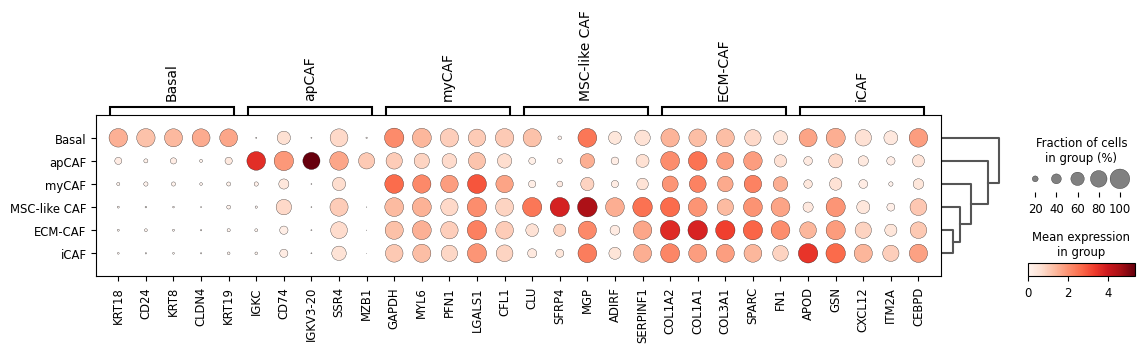

In [8]:
sc.tl.rank_genes_groups(adata_Fib, groupby='Fib-type', method='wilcoxon')
sc.tl.dendrogram(adata_Fib, groupby='Fib-type')
sc.pl.rank_genes_groups_dotplot(adata_Fib, groupby='Fib-type', n_genes=5, save='-Fibro.svg')

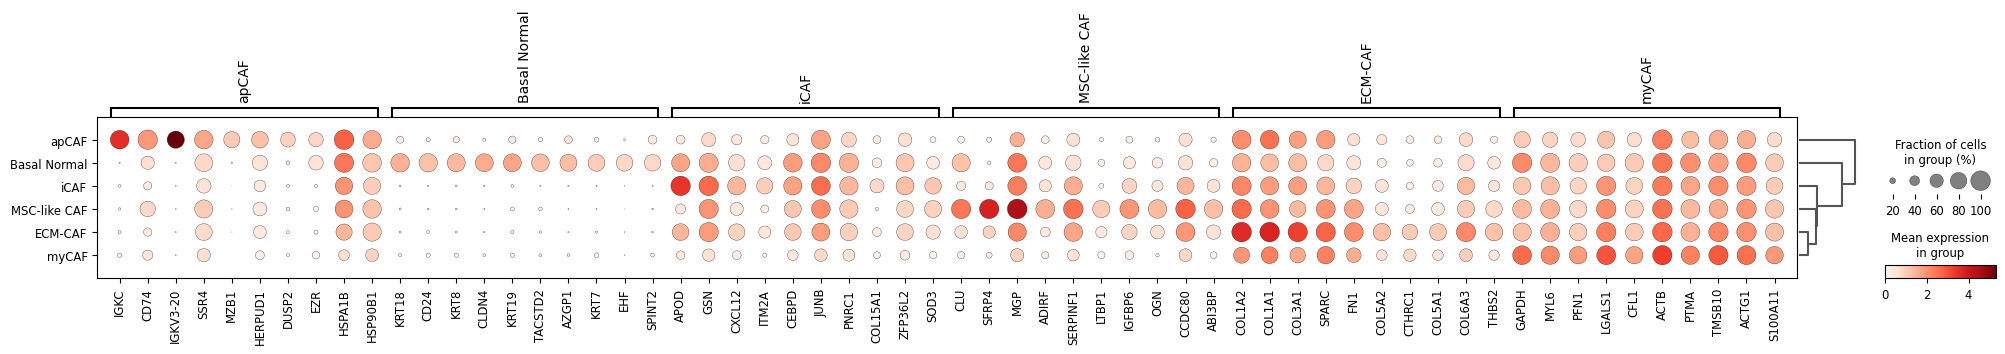

In [23]:
adata_Fib = marker(adata_Fib, 'Fib-type')

/tmp/ipykernel_1503905/1401033485.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_type_counts = adata_Fib.obs.groupby(['batch', 'Fib-type']).size().unstack(fill_value=0)


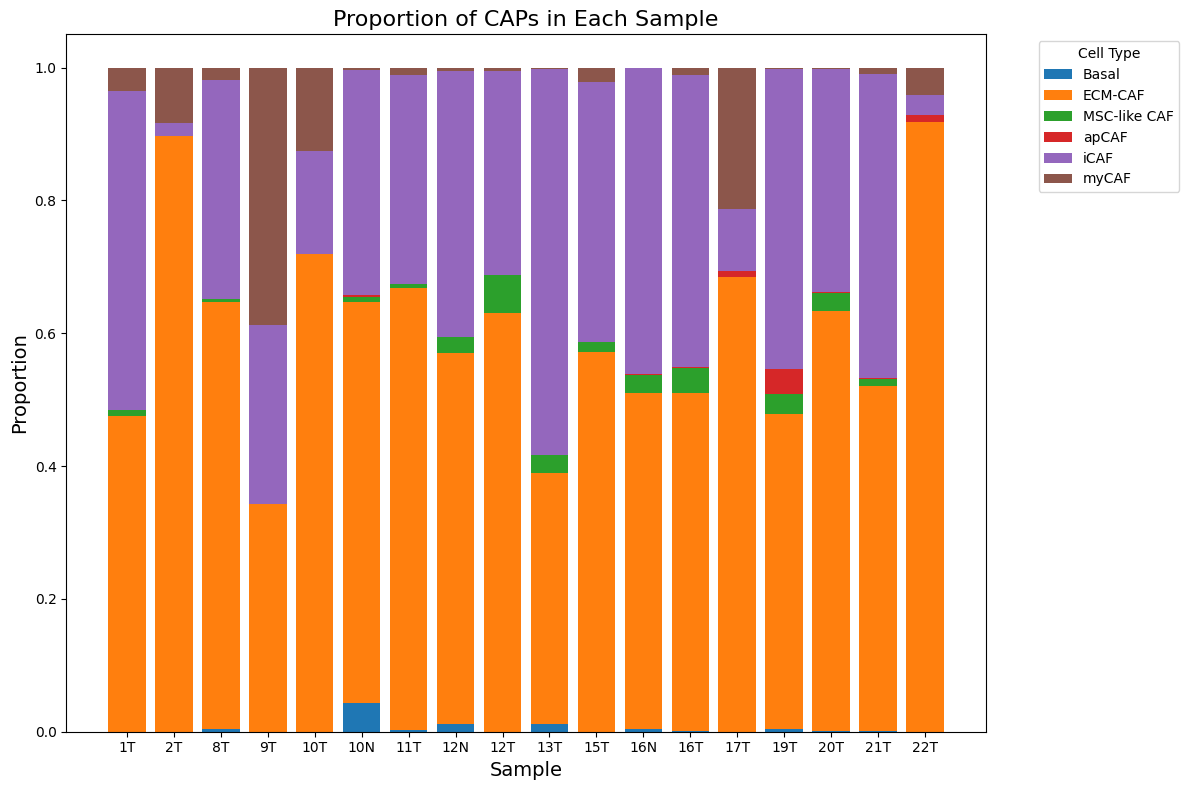

In [9]:
# 1. 计算每个样本中每种细胞类型的数量
cell_type_counts = adata_Fib.obs.groupby(['batch', 'Fib-type']).size().unstack(fill_value=0)

# 2. 计算每个样本的总细胞数
sample_totals = cell_type_counts.sum(axis=1)

# 3. 计算每种细胞类型在每个样本中的占比
proportions = cell_type_counts.div(sample_totals, axis=0)

# 4. 绘制堆叠条形图
fig, ax = plt.subplots(figsize=(12, 8))

# 遍历每个细胞类型，逐层堆叠
bottom = np.zeros(len(cell_type_counts.index))  # 初始化底部高度
for cell_type in proportions.columns:
    ax.bar(proportions.index, proportions[cell_type], bottom=bottom, label=cell_type)
    bottom += proportions[cell_type]  # 更新底部高度

# 添加标题和标签
ax.set_title('Proportion of CAPs in Each Sample', fontsize=16)
ax.set_xlabel('Sample', fontsize=14)
ax.set_ylabel('Proportion', fontsize=14)
ax.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# 显示图形
plt.tight_layout()
plt.show()

#### GO&KEGG&Hallmark功能富集分析

In [ ]:
adata_Fib_tumor = adata_Fib[adata_Fib.obs['treat'] != 'Normal', :]

In [ ]:
adata_Fib_tumor

In [ ]:
sc.tl.rank_genes_groups(adata_Fib_tumor, groupby='treat',method='wilcoxon')
sc.tl.dendrogram(adata_Fib_tumor, groupby='treat')
sc.pl.rank_genes_groups_dotplot(adata_Fib_tumor, n_genes=10, groupby='treat')

In [ ]:
import gseapy as gp
from gseapy import Msigdb
msig = Msigdb()
gmt = msig.get_gmt(category='mh.all', dbver="2023.2.Hs")
gmt

In [ ]:
# get deg result
result = adata_Fib_tumor.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs = pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names','scores', 'pvals','pvals_adj','logfoldchanges']})
degs

In [ ]:
# subset up or down regulated genes
degs_sig = degs[degs.After_pvals_adj < 0.05]
degs_up = degs_sig[degs_sig.After_logfoldchanges > 0.5]
degs_dw = degs_sig[degs_sig.After_logfoldchanges < -0.5]

In [ ]:
enr_up = gp.enrichr(degs_up.After_names,
                    gene_sets='KEGG_2021_Human',
                    outdir=None)
cc_up = gp.enrichr(degs_up.After_names,
                    gene_sets='GO_Cellular_Component_2023',
                    outdir=None)
bp_up = gp.enrichr(degs_up.After_names,
                    gene_sets='GO_Biological_Process_2023',
                    outdir=None)
mf_up = gp.enrichr(degs_up.After_names,
                    gene_sets='GO_Molecular_Function_2023',
                    outdir=None)
hm_up = gp.enrichr(degs_up.After_names,
                    gene_sets='MSigDB_Hallmark_2020',
                    outdir=None)

In [ ]:
enr_down = gp.enrichr(degs_dw.After_names,
                    gene_sets='KEGG_2021_Human',
                    outdir=None)
cc_down = gp.enrichr(degs_dw.After_names,
                    gene_sets='GO_Cellular_Component_2023',
                    outdir=None)
bp_down = gp.enrichr(degs_dw.After_names,
                    gene_sets='GO_Biological_Process_2023',
                    outdir=None)
mf_down = gp.enrichr(degs_dw.After_names,
                    gene_sets='GO_Molecular_Function_2023',
                    outdir=None)
hm_down = gp.enrichr(degs_dw.After_names,
                    gene_sets='MSigDB_Hallmark_2020',
                    outdir=None)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 拼接所有up和down富集结果
def prepare_df(df, label):
    df = df.copy()
    df['Gene_set'] = label
    return df

# 合并top15条目来自每个数据库
df_up = pd.concat([
    prepare_df(enr_up.res2d.head(5), 'KEGG')
])
df_down = pd.concat([
    prepare_df(enr_down.res2d.head(5), 'KEGG')
])

# 添加方向、统一-log10(pval)
df_up['Direction'] = 'Up'
df_up['logp'] = -np.log10(df_up['P-value'])

df_down['Direction'] = 'Down'
df_down['logp'] = np.log10(df_down['P-value'])  # 注意：下调做正方向方便镜像

# 合并并整理
df_all = pd.concat([df_up, df_down])
df_all['Term'] = df_all['Term'].str.replace('_', ' ')
df_all['Term'] = df_all['Term'].str[:60]  # 避免标签过长

# 设置颜色
palette = {
    'KEGG': '#8b9cc4'
}

# 排序绘图
df_all = df_all.sort_values('logp')
plt.figure(figsize=(10, 6))

# 条形图
sns.barplot(
    data=df_all,
    y='Term',
    x='logp',
    hue='Gene_set',
    palette=palette,
    dodge=False
)

# 设置参考线与图例
plt.axvline(0, color='black', linestyle='--')
plt.xlabel('-log10(p-value) (Up on right, Down on left)')
plt.ylabel('')
plt.title("Enrichment of Up and Down Regulated Genes in Tumor Endo")
plt.legend(title='Gene Set', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("figures/After_Fibro_KEGG_Enrichment_UPvsDOWN.svg")
plt.show()

In [ ]:
go_res = pd.concat([enr_up.res2d.head(15),hm_up.res2d.head(15), cc_up.res2d.head(15), bp_up.res2d.head(15), mf_up.res2d.head(15)])
ax = gp.barplot(go_res, figsize=(6,20),
                group ='Gene_set',
                top_term=15,
                color = ['#8b9cc4', '#f08961', '#62bb9f', '#e71f19', '#3d5eaa'],
                title ="The Most Enriched Terms Up in Tumor Fibro After")
ax.figure.savefig(f"figures/Fibro_After_Enrichment_UP.svg")

In [ ]:
godown_res = pd.concat([enr_down.res2d.head(15),hm_down.res2d.head(15), 
                    cc_down.res2d.head(15), bp_down.res2d.head(15), mf_down.res2d.head(15)])
ax = gp.barplot(godown_res, figsize=(6,20),
                group ='Gene_set',
                top_term=15,
                color = ['#8b9cc4', '#f08961', '#62bb9f', '#e71f19', '#3d5eaa'],
                title ="The Most Enriched Terms Down in Tumor Fibro After")
ax.figure.savefig(f"figures/Fibro_After_Enrichment_DOWN.svg")

In [10]:
adata_Fib.write_h5ad("adata-Fib.h5ad")